In [1]:
from model import *
from sortedlist import *
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
sns.set()

In [2]:
L = 5000
test = SortedList.fromlist(np.abs(np.random.normal(np.sqrt(10)*L, 0.1*L, size=L) + 0.45*L*np.random.randint(2,size=L)).astype(int))
print(test[:20])

[14205, 14226, 14255, 14281, 14312, 14357, 14368, 14382, 14387, 14388, 14399, 14453, 14461, 14468, 14477, 14495, 14515, 14515, 14525, 14528]


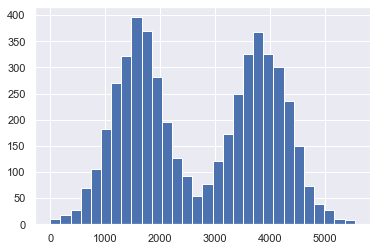

[[[  0.]]

 [[ 21.]]

 [[ 50.]]

 [[ 76.]]

 [[107.]]] [[[0.]]

 [[1.]]

 [[2.]]

 [[3.]]

 [[4.]]]


In [3]:
tests = enumerate(test)
testy, testx = zip(*tests)
testx = np.array(list(testx), dtype=np.float64).reshape(-1,1,1)
testx -= min(testx)
testy = np.array(list(testy), dtype=np.float64).reshape(-1,1,1)
plt.hist(testx.flatten(), bins=30)
plt.show()
print(testx[:5],testy[:5])
dataset = np.array([testx.flatten(), testy.flatten()]).reshape(2,-1,1)
with open("bimodal6m.data", "wb") as f:
    pickle.dump(dataset, f)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

FITTING RMI MODEL WITH BATCH SIZE 64


(S2, M50)  Finished Epoch #100  MaxAE 4037.6318359375 Mean AE 371.49859619140625:   2%| | 2/100 [00:55<45:42, 27.98s/it


335.48486 43.306007


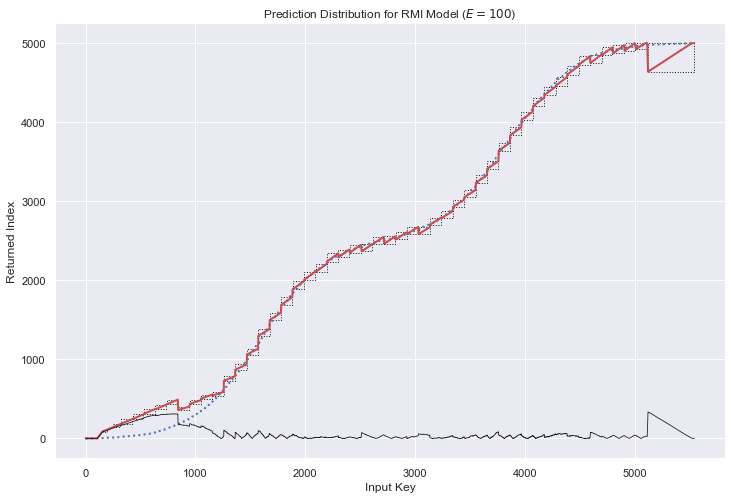

In [14]:
# From StackOverflow User EwyynTomato
def listRightIndex(alist, value):
    return len(alist) - alist[-1::-1].index(value) -1

from matplotlib.patches import Rectangle
n_epochs=100
adam = keras.optimizers.Adam(learning_rate=1e-3)
sgd = keras.optimizers.SGD(learning_rate=1.0, nesterov=False)
mae, aae = MaxAbsoluteError(), keras.metrics.MeanAbsoluteError()
model = build_fit_rmi_model(dataset, stages=(1,50), n_layers=0, n_neurons=32, 
                            n_epochs=n_epochs, initializer='identity', verbose=False, 
                            optimizer=adam, loss='mse', metrics=[mae, aae])
preds, lf = predict_rmi_model(model, dataset, with_leaf=True)
mae = MaxAbsoluteError()
mae.update_state(testy.flatten().astype('float32'), preds.flatten().astype('float32'))
mae = mae.result().numpy()
aae = keras.metrics.MeanAbsoluteError()
aae.update_state(testy.flatten().astype('float32'), preds.flatten().astype('float32'))
aae = aae.result().numpy()
print(mae, aae)
lfo = list(lf.copy())
lf, lfcounts = np.unique(lf, return_counts=True)
lfidxs = [(lfo.index(i), listRightIndex(lfo, i)) for i in lf]
mkrs = []
mkrhts = []
for i in range(len(lfidxs)):
    mkrs.append((int(testx.flatten()[lfidxs[i][0]]),int(testx.flatten()[lfidxs[i][1]])))
    mkrhts.append((preds[lfidxs[i][0]],preds[lfidxs[i][1]]))
fig, ax = plt.subplots()
seps = np.linspace(0, len(testx), 50)
ax.set_ylabel("Placement of Index")
gtruth = testx.flatten()
gtruth -= min(gtruth)
gtruth /= max(gtruth)
gtruth *= len(gtruth)
root = new_stage_model()
ax.plot(testx.flatten(), testy.flatten(), linestyle='dotted', lw=2)
ax.plot(testx.flatten(), preds, lw=2, c='r')
ax.plot(testx.flatten(), abs(testy.reshape(-1)-preds.reshape(-1)), lw=0.8, c='k')
ax.set_title(f"Prediction Distribution for RMI Model ($E={n_epochs}$)")
ax.set_xlabel("Input Key")
ax.set_ylabel("Returned Index")
for m in range(len(mkrs)):
    ax.add_patch(Rectangle((mkrs[m][0], mkrhts[m][0]), mkrs[m][1]-mkrs[m][0], mkrhts[m][1] - mkrhts[m][0], facecolor='none', edgecolor='k', linestyle='dotted'))
fig.set_size_inches((12,8))
plt.show()

In [12]:
cumloss = []
max_epoch = 50
for n_epochs in range(1,max_epoch+1):
    model = build_fit_rmi_model(dataset, n_neurons=128, n_epochs=n_epochs, optimizer=keras.optimizers.Adam(learning_rate=5e-4), loss='mse', verbose=0)

    preds = predict_rmi_model(model, testx)
    mse = keras.metrics.MeanSquaredError()
    mse.update_state(preds, testy.reshape(-1,1))
    cumloss.append(mse.result().numpy())
    
    c = np.c_[preds, testy.reshape(-1,1)]

    fig, (ax, lax) = plt.subplots(2,1)
    seps = np.arange(0, len(testx), 2)
    linax = ax.twinx()
    linax.set_ylabel("Placement of Index")
    linax.set_ylim(0, len(testx))
    linax.plot(range(len(testx)), range(len(testx)), linestyle='dotted', lw=2)
    linax.plot(range(len(testx)), preds, lw=2, c='r')
    ax.hist(preds.reshape(-1), bins=seps, alpha=0.4, label='Predicted')
    ax.hist(testy.reshape(-1), bins=seps, alpha=0.4, label='Actual')
    ax.set_title(f"Prediction Distribution for RMI Model ($E={n_epochs}$)")
    ax.set_xlabel("Returned Index")
    ax.set_ylabel("Frequency")
    ax.set_ylim(0,5)
    ax.legend(loc='upper left')
    lax.plot(range(len(cumloss)), np.log10(cumloss), c='k')
    lax.set_title("LogMSE Over Epochs")
    lax.set_xlabel("# Epoch")
    lax.set_ylabel("LogMSE")
    lax.set_xlim(0,max_epoch)
    lax.set_ylim(0,5)
    fig.set_size_inches((12,12))
    # plt.show()
    plt.tight_layout()
    plt.savefig(f"modeling_imgs/n_epochs_{n_epochs}.png")
    plt.close()
    print(f"{n_epochs}...", end=' ')

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

FITTING RMI MODEL WITH BATCH SIZE 64


(S1, M1)  Finished Epoch #1  MaxAE 0.0 Mean AE 0.0:   0%|                                        | 0/1 [00:00<?, ?it/s]

(S3, M4)  Finished Epoch #1  MaxAE 0.0 Mean AE 0.0: : 3it [00:02,  1.01it/s]                                           


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 5000

In [2]:
exm = new_stage_model(n_neurons=8, n_layers=1)
# exm.add_metric(keras.metrics.Sum(name='sum1')(exm.outputs), name='sum')
exm.compile(loss='mse', optimizer='adam', 
            metrics=[MaxAbsoluteError()])
exhist = exm.fit(dataset, epochs=100)
mape = exhist.history['max_absolute_error']
los = exhist.history['loss']
fig, (mapeax, lax, hax) = plt.subplots(3,1)
mapeax.plot(range(len(mape)), mape)
mapeax.set_title("MaxAE in training")
mapeax.set_xlabel("Epoch #")
mapeax.set_xticks(range(0,len(mape),5))
mapeax.set_ylabel("MaxAE")
lax.plot(range(len(mape)), los)
lax.set_title("MSE Loss in training")
lax.set_xlabel("Epoch #")
lax.set_xticks(range(0,len(mape),5))
lax.set_ylabel("MSE Loss")
lax.set_yscale('log')
preds = exm.predict(testx) + 1
seps = np.arange(0,L,max(1,L//25))
hax.hist(preds.reshape(-1), bins=seps, alpha=0.4, label='Predicted')
hax.hist(testy.reshape(-1), bins=seps, alpha=0.4, label='Actual')
hax.set_title("Key Distribution")
hax.set_xlim(0,L)
hax.set_ylim(0,L//2)
hax.set_xlabel("Key index")
hax.set_ylabel("Frequency")
hax.legend()
fig.set_size_inches((12,12))
plt.tight_layout()
plt.show()

NameError: name 'new_stage_model' is not defined

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]